# CO543: Image Processing - Lab 2 (2025)
### E/21/245 - MADHUSHAN S.K.A.K.

## Task 1 — Visualize Intensity & Histograms

importing the relevent libraries

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

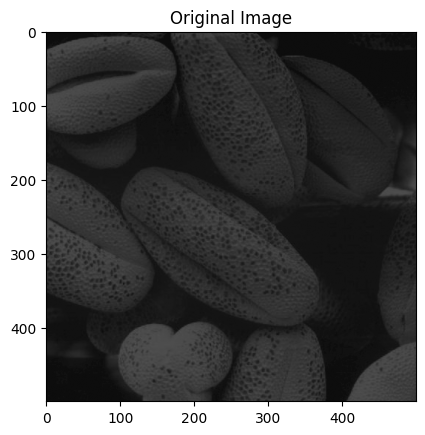

In [37]:
img =cv2.imread('dark.tif',0)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Original Image')
plt.show()


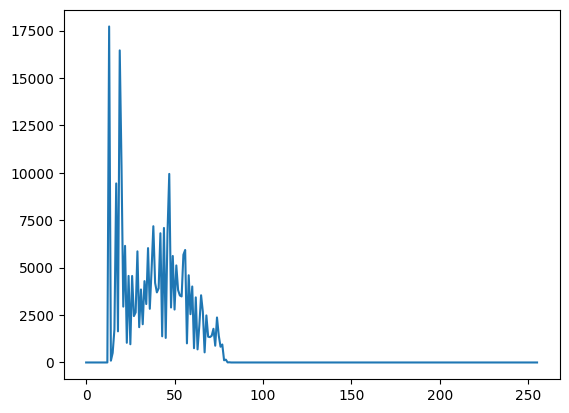

In [38]:
# cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])
hist = cv2.calcHist([img], [0], None , [256], [0,256])
plt.plot(hist)

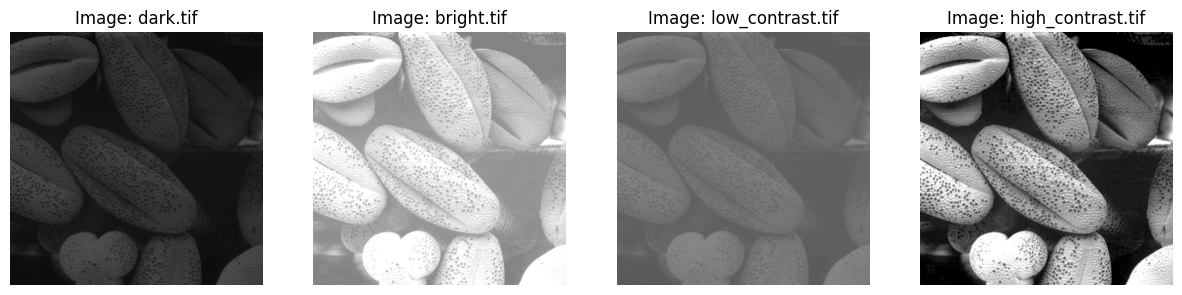

In [40]:
image_files = ['dark.tif', 'bright.tif', 'low_contrast.tif', 'high_contrast.tif']
plt.figure(figsize=(15,5))

for i, filename in enumerate(image_files):
    img_ = cv2.imread(filename, 0)

    if img_ is None:
        print(f"Error: Could not open or find the image {filename}.")
        continue
    plt.subplot(1, len(image_files), i+1)
    plt.imshow(img_, cmap='gray', vmin=0, vmax=255)
    plt.title(f'Image: {filename}')
    plt.axis('off')
plt.show()

Let see all the given images to see how the histrogram is drawn

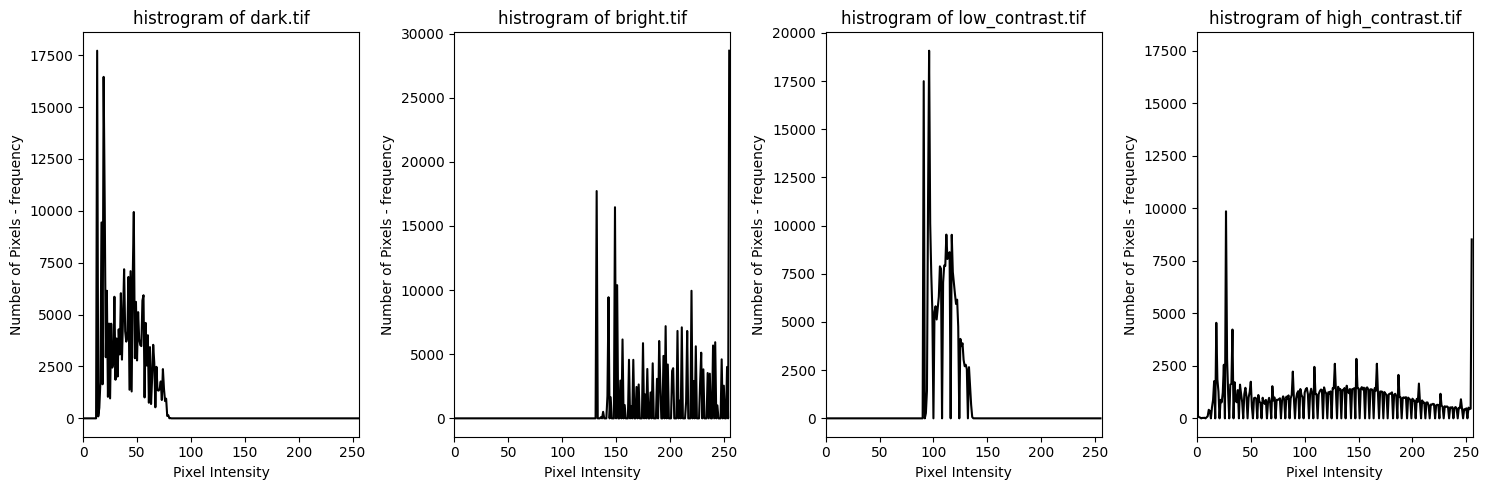

In [41]:
plt.figure(figsize=(15,5))

for i, filename in enumerate(image_files):
    img_ = cv2.imread(filename, 0)

    if img_ is None:
        print(f"Error: Could not open or find the image {filename}.")
        continue
    hist = cv2.calcHist([img_], [0], None , [256], [0,256])

    plt.subplot(1, len(image_files), i+1)
    plt.title(f"histrogram of {filename}")
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Number of Pixels - frequency')
    plt.plot(hist, color='black')
    plt.xlim([0,256])
plt.tight_layout()
plt.show()

### Observations

When I plotted the histograms for the three images, I immediately noticed a clear link between the graph shape and the image quality. For the dark image, the pixel data was clustered heavily on the left side, which I suppose makes sense since those are the low intensity values. In contrast, the bright image showed a distribution pushed way over to the right. I thought the most interesting one was the low contrast image; its histogram was just a narrow spike in the middle, showing that it lacked any deep blacks or bright whites. As I see it, checking this distribution is essential because it mathematically confirms the lighting conditions before I decide how to process or enhance the image.

### More to think:​
**If two images have similar histograms, can they still look visually different? Why?**

Yes, absolutely.

The Logic:- A histogram contains only statistical information (the count of pixels), but it contains zero spatial information (the location of pixels).he histogram tells you what is in the image, but not where it is.

## Task 2 — Manual Threshold & Observe Failure Cases

In [44]:

fixed_thresh_value = 100 

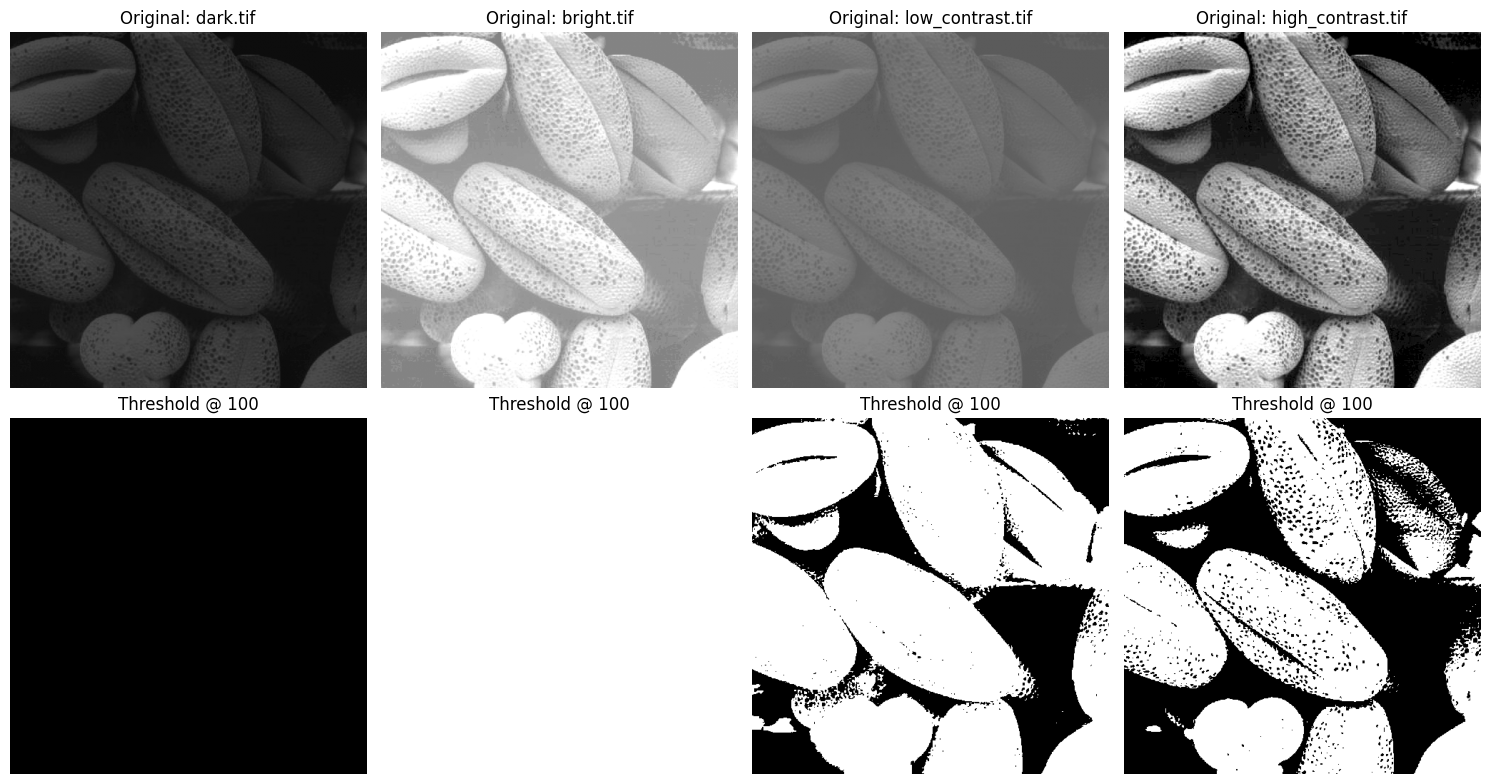

In [46]:

fig, axes = plt.subplots(2, 4, figsize=(15, 8)) 

for i, filename in enumerate(image_files):
    img = cv2.imread(filename, 0)
    
    # Thresholding
    _, binary_img = cv2.threshold(img, fixed_thresh_value, 255, cv2.THRESH_BINARY)
    
    # Plot Original (Top Row)
    axes[0, i].imshow(img, cmap='gray', vmin=0, vmax=255)
    axes[0, i].set_title(f"Original: {filename}")
    axes[0, i].axis('off')

    # Plot Thresholded (Bottom Row)
    axes[1, i].imshow(binary_img, cmap='gray', vmin=0, vmax=255)
    axes[1, i].set_title(f"Threshold @ {fixed_thresh_value}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Observations

I applied a fixed threshold of 100 to all four images to test if a single value could handle different lighting. The results showed a complete failure for the extreme lighting cases. For the `dark.tif image`, the result was a completely black square because all pixels were below 100. Conversely, `bright.tif` became a solid white square because its pixel values were all above the threshold.

The method only worked reasonably well for the `high_contrast.tif` image, where the separation between object and background was naturally distinct. The `low_contrast.tif` image showed identifiable objects, but the segmentation was rough and noisy. This visually confirms that we cannot use a static threshold for dynamic lighting conditions; the threshold must adapt to the image data

### More to think:​
Is thresholding really “deciding” what an object is, or just comparing brightness?

Answer:-  It is definitely just comparing brightness

The Logic:- Thresholding is a "dumb" operation. It follows a simple if/else statement
(like If intensity > T give that to 1 and else 0) Thresholding does not recognize objects; it only isolates intensity. Recognition comes later with more advanced algorithms (like contour detection or neural networks).

## Task 3 — Apply Otsu & Adaptive Thresholding

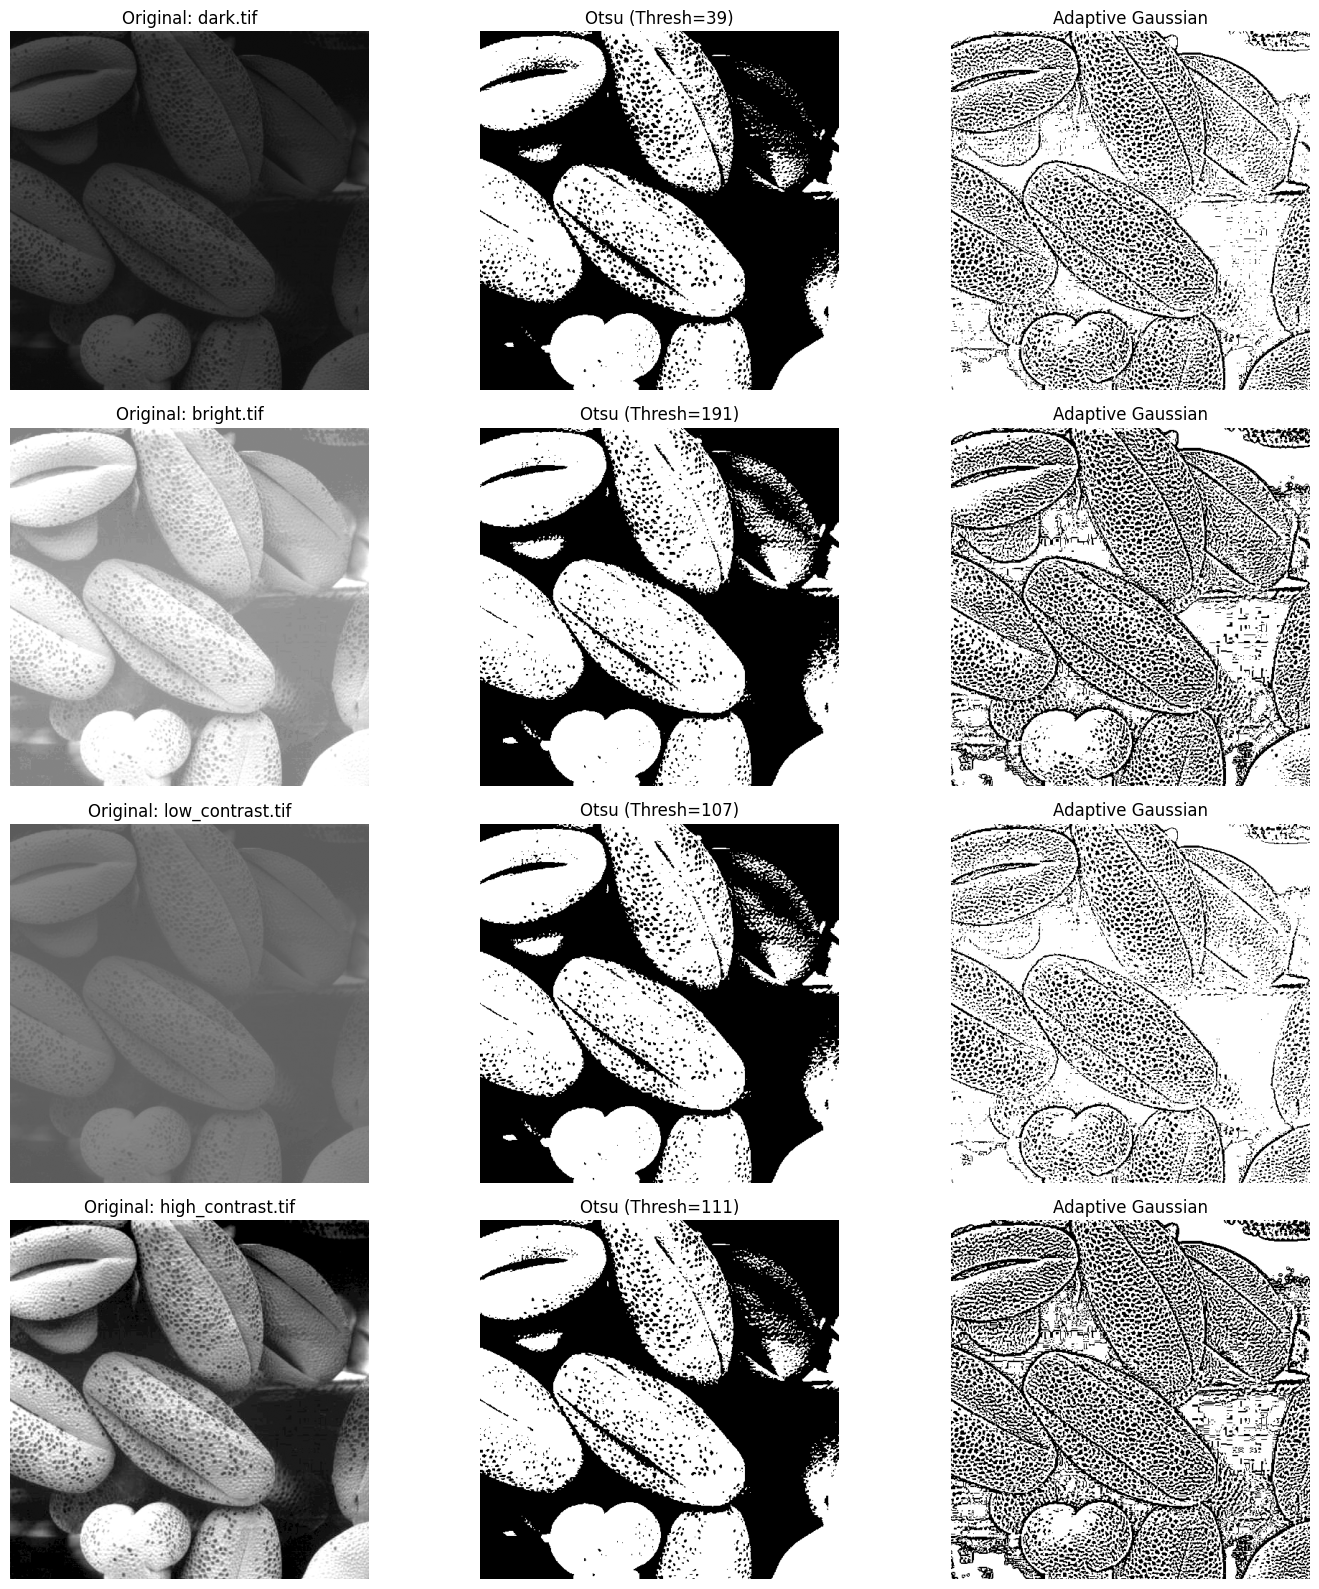

In [51]:

fig, axes = plt.subplots(len(image_files), 3, figsize=(15, 4 * len(image_files))) 

for i, filename in enumerate(image_files):
    img = cv2.imread(filename, 0)

    if img is None:
        print(f"Error: Could not open or find the image {filename}.")
        continue

    # Method 1 - Otsu's Thresholding
    ret, otsu = cv2.threshold(img, 0, 255 , cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #Method 2 - Adaptive Thresholding 
    adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # 1. Original image 
    axes[i, 0].imshow(img, cmap='gray', vmin=0, vmax=255)
    axes[i, 0].set_title(f"Original: {filename}")
    axes[i, 0].axis('off')
    
    # 2. Otsu (Global Smart) images
    axes[i, 1].imshow(otsu, cmap='gray', vmin=0, vmax=255)
    axes[i, 1].set_title(f"Otsu (Thresh={int(ret)})") # Shows the number it chose!
    axes[i, 1].axis('off')
    
    # 3. Adaptive (Local Smart) images
    axes[i, 2].imshow(adaptive, cmap='gray', vmin=0, vmax=255)
    axes[i, 2].set_title("Adaptive Gaussian")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

### Observations

I compared the manual way with Otsu and Adaptive thresholding, and the difference was big. Before, I used one fixed number and it failed. But Otsu's method is smart; it found the best number for each image automatically. For example, it picked 39 for the dark image and 191 for the bright one. This made the object shapes look solid and clear. Then I tried Adaptive thresholding. It works differently. It looks at small details, so I could see the texture on the surface. But the problem is, it also created a lot of noise in the background that Otsu didn't have.

### More to think
Why can adaptive thresholding still struggle on textured backgrounds?

Answer:- 
I think the reason is that the algorithm looks at the image too closely. It checks every small area to find differences in brightness. If the background has a rough texture, it has tiny shadows and highlights. The algorithm mistakes these tiny shadows for actual objects or edges. So, instead of ignoring the background, it tries to outline every little bump, which creates a messy, noisy image.

In [52]:
img_dark = cv2.imread('dark.tif', 0)
img_bright = cv2.imread('bright.tif', 0)

#### Gamma correction :-

In [53]:
# Gamma Correction (dark image -> Brighten)
gamma_low = 0.7 # Gamma < 1 makes things brighter
gamma_high = 2.0 # Gamma > 1 makes things darker

In [54]:
dark_img_corrected = np.power(img_dark / 255.0, gamma_low) * 255.0
dark_img_corrected = np.uint8(dark_img_corrected) # Convert back to standard image format

In [55]:
bright_img_corrected = np.power(img_bright / 255.0, gamma_high) * 255.0
bright_img_corrected = np.uint8(bright_img_corrected) # Convert back to standard image format

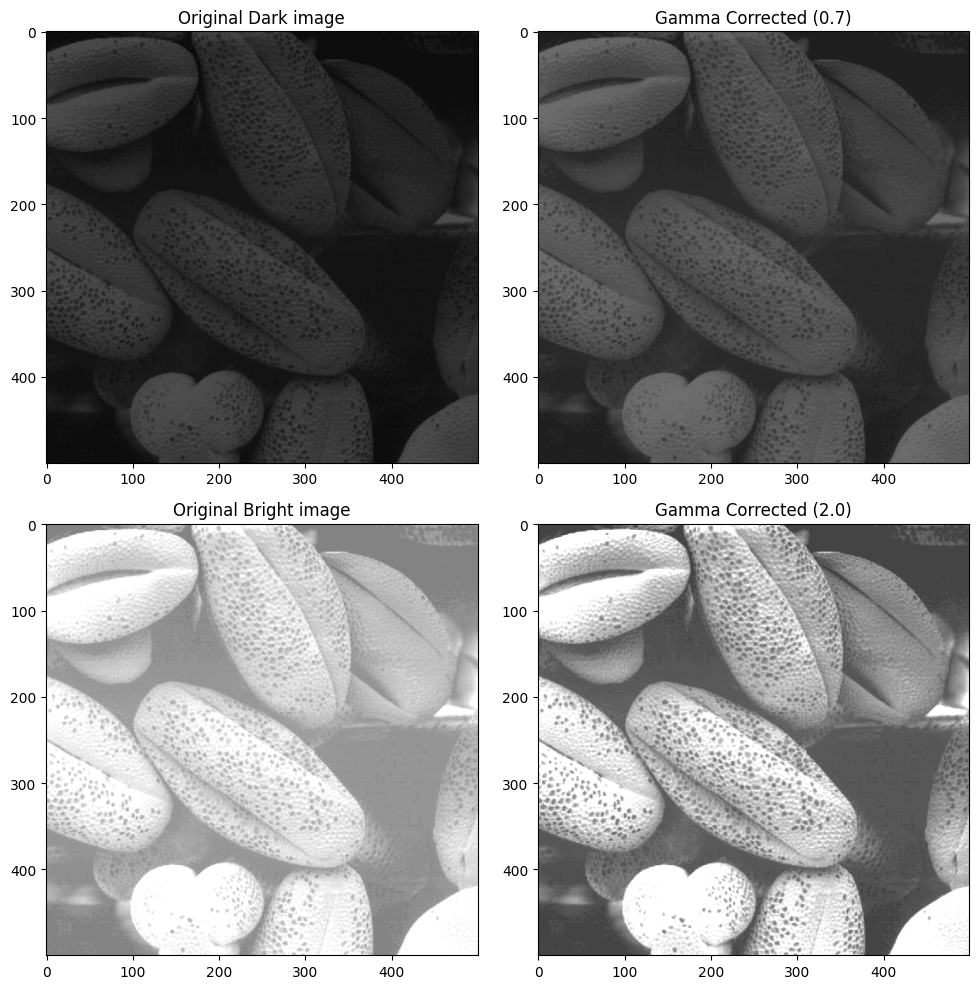

In [56]:
# Visualizing the p;ots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot Dark Correction
axes[0,0].imshow(img_dark, cmap='gray', vmin=0, vmax=255)
axes[0,0].set_title("Original Dark image")
axes[0,1].imshow(dark_img_corrected, cmap='gray', vmin=0, vmax=255)
axes[0,1].set_title(f"Gamma Corrected ({gamma_low})")

# Plot Bright Correction
axes[1,0].imshow(img_bright, cmap='gray', vmin=0, vmax=255)
axes[1,0].set_title("Original Bright image")
axes[1,1].imshow(bright_img_corrected, cmap='gray', vmin=0, vmax=255)
axes[1,1].set_title(f"Gamma Corrected ({gamma_high})")

plt.tight_layout()
plt.show()

### Observations
First, I used Gamma correction to fix the exposure issues. For the dark image, I used a Gamma value of 0.7. This worked like a digital flash, brightening the hidden details without washing out the image. For the bright image, I used a Gamma of 2.0, which darkened the highlights and brought back the texture that was lost in the glare. I think this is really useful because it mimics how a camera adjusts exposure, letting us balance the light mathematically

#### Log Transfromation :- 

In [57]:
c =  255 / np.log(1 + np.max(img_dark))
log_image = c * (np.log(1 + img_dark))
log_image = np.array(log_image, dtype = np.uint8)

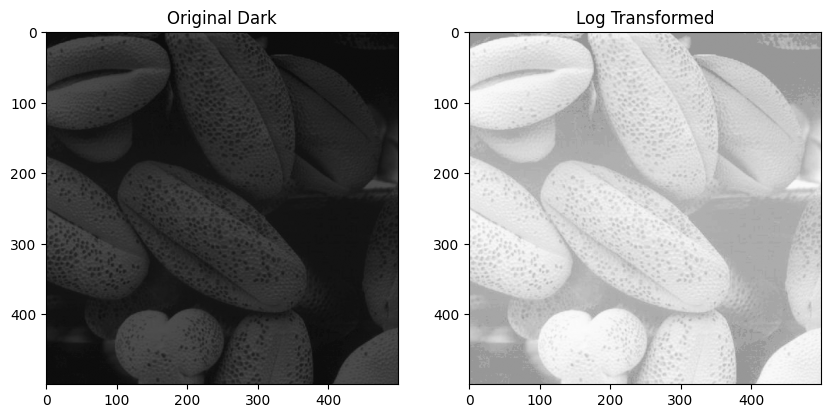

In [58]:
# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_dark, cmap='gray', vmin=0, vmax=255)
plt.title("Original Dark")

plt.subplot(1, 2, 2)
plt.imshow(log_image, cmap='gray', vmin=0, vmax=255)
plt.title("Log Transformed")
plt.show()

### Observations
Next, I tried the Log transformation on the dark image. This method expanded the dark pixels very aggressively. It felt similar to the Gamma correction, but I noticed it was particularly good at picking up the faintest details in the shadows. this method is best used when we have an image with a huge range of light levels—like a night scene—where we need to see into the darkest corners

### More to Think
Does gamma correction change object identity or only perception?

The answer is no, it only changes perception. We are not adding or removing any objects; we are just changing the brightness of the pixels that are already there. A cup is still a cup, whether it is in a dark room or a bright room. We are just turning on the lights.

## Task 5 — Contrast Stretching & Histogram Equalization

In [59]:
# Original low contrast image
img = cv2.imread('low_contrast.tif', 0)

In [60]:
# Contrast Stretching
stretched_img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

In [61]:
# Historam Equalization
hist_eq_img = cv2.equalizeHist(img)

In [62]:
# Calculate the Histograms
hist_original = cv2.calcHist([img], [0], None , [256], [0,256])
hist_stretched = cv2.calcHist([stretched_img], [0], None , [256], [0,256])
hist_hist_eq = cv2.calcHist([hist_eq_img], [0], None , [256], [0,256])  

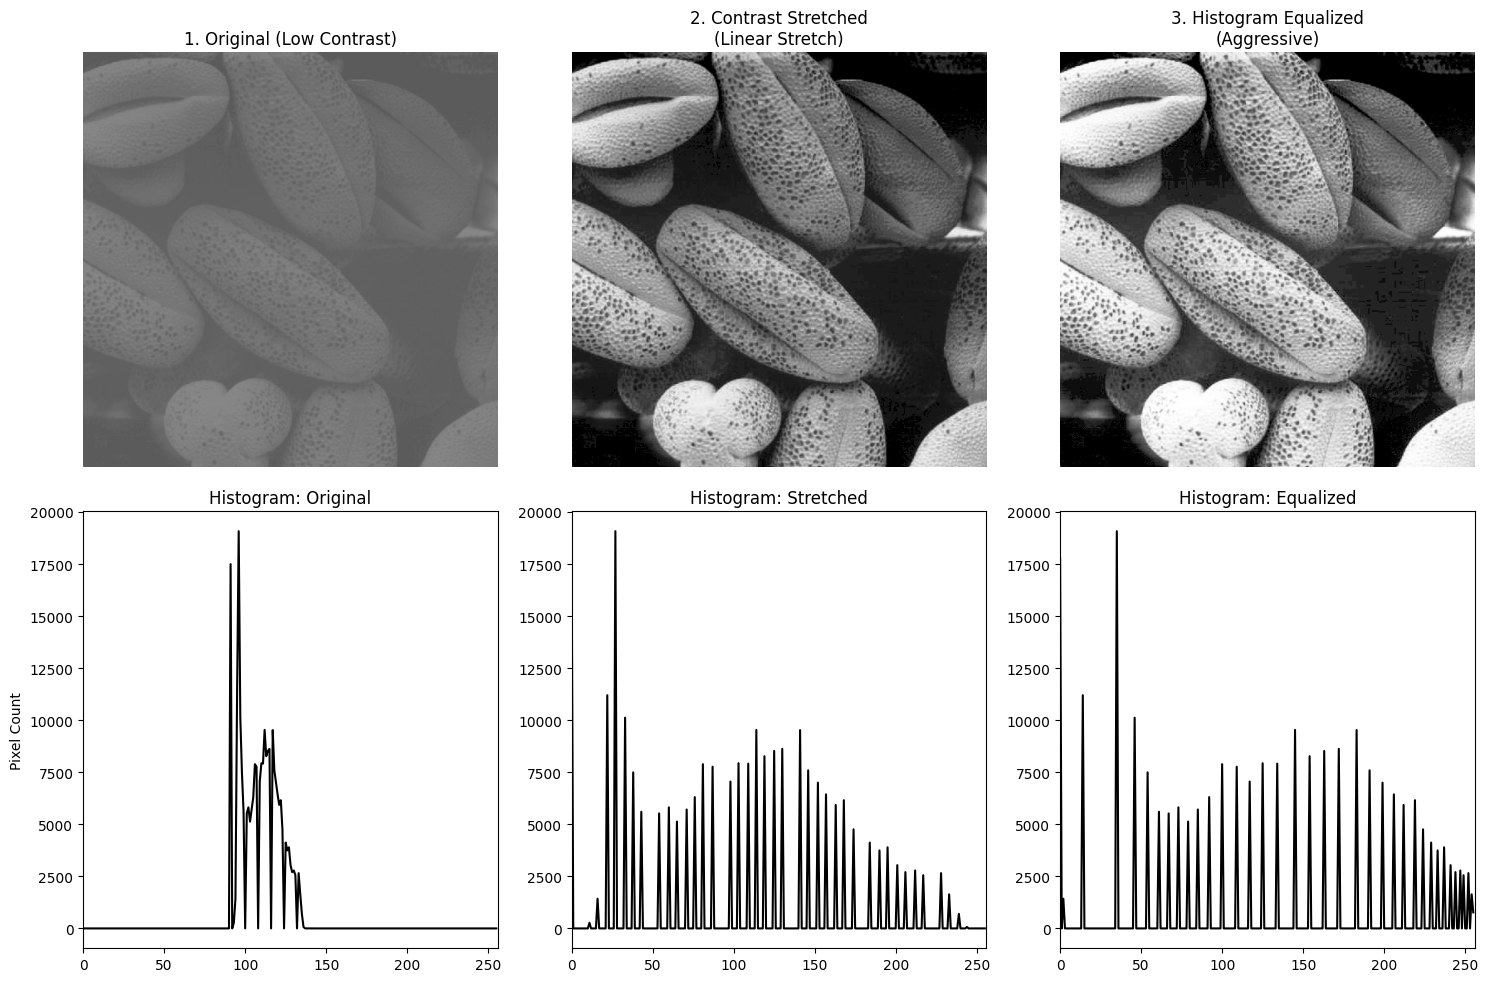

In [63]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: The Images
# 1. Original
axes[0, 0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0, 0].set_title("1. Original (Low Contrast)")
axes[0, 0].axis('off')

# 2. Contrast Stretched
axes[0, 1].imshow(stretched_img, cmap='gray', vmin=0, vmax=255)
axes[0, 1].set_title("2. Contrast Stretched\n(Linear Stretch)")
axes[0, 1].axis('off')

# 3. Histogram Equalized
axes[0, 2].imshow(hist_eq_img, cmap='gray', vmin=0, vmax=255)
axes[0, 2].set_title("3. Histogram Equalized\n(Aggressive)")
axes[0, 2].axis('off')

# Row 2: The Histograms (Showing the Intensity Change)
# 1. Original Histogram (Clustered)
axes[1, 0].plot(hist_original, color='black')
axes[1, 0].set_title("Histogram: Original")
axes[1, 0].set_xlim([0, 256])
axes[1, 0].set_ylabel("Pixel Count")

# 2. Stretched Histogram (Spread but same shape)
axes[1, 1].plot(hist_stretched, color='black')
axes[1, 1].set_title("Histogram: Stretched")
axes[1, 1].set_xlim([0, 256])

# 3. Equalized Histogram (Flattened/Spread everywhere)
axes[1, 2].plot(hist_hist_eq, color='black')
axes[1, 2].set_title("Histogram: Equalized")
axes[1, 2].set_xlim([0, 256])

plt.tight_layout()
plt.show()

### Observations

I performed contrast stretching first, followed by histogram equalization, and plotted the histograms to see exactly how the pixel intensities changed. For contrast stretching, the histogram showed that the original 'shape' of the data was preserved; it was simply stretched out to cover the full range from black to white. This resulted in a clear, natural-looking image. However, when I ran histogram equalization, the histogram plot looked completely different—the pixel values were forcefully redistributed across the entire spectrum to maximize contrast. While this made the details very sharp, I noticed it also amplified the noise in the background because it didn't respect the natural distribution of the light.


### More to think:​

When can histogram equalization amplify noise instead of details?
Histogram equalization struggles when an image has large, smooth areas like a blank wall or a dark background. In these areas, the pixels have very similar values. The algorithm tries to force these values apart to flatten the histogram, which stretches tiny, invisible variations into large, visible differences. This creates a grainy, 'noisy' look in areas that should be smooth, effectively amplifying the noise rather than the actual details.


## Task 6 — Bit-Plane Slicing


In [64]:
img = cv2.imread('dark.tif', 0)

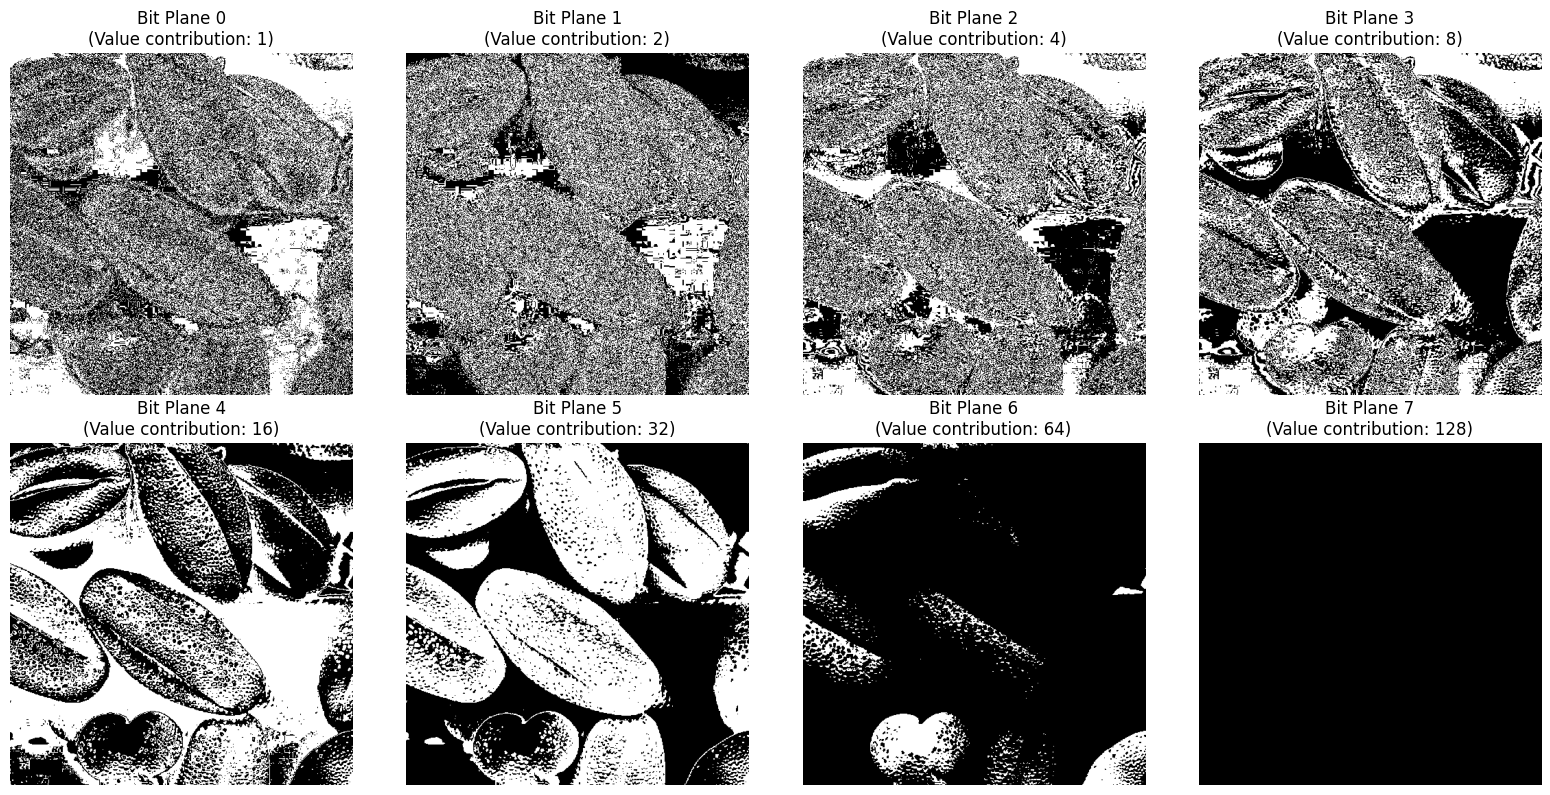

In [65]:
# Create a grid for 8 bit planes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Loop through bits 0 to 7
for n in range(8):
    # Create a mask for the specific bit
    # Perform bitwise AND to isolate that bit
    bit_plane = cv2.bitwise_and(img, 2**n)
    
    # Scale to 0-255 just for visualization visibility
    # If the bit is present, make it white (255). If not, black (0).
    plane_display = (bit_plane > 0).astype(np.uint8) * 255
    
    # Plotting
    axes[n].imshow(plane_display, cmap='gray',vmax=255, vmin=0)
    axes[n].set_title(f"Bit Plane {n}\n(Value contribution: {2**n})")
    axes[n].axis('off')

plt.tight_layout()
plt.show()

### Observaitons
The bit-plane slicing results revealed the internal structure of the `dark.tif image`. The lower bit planes (Bits 0–2) consisted mostly of random static, confirming that the least significant bits primarily contain sensor noise rather than structural data. As I moved to the middle bits (Bits 3–5), the object shapes became clear. Interestingly, the most significant bit plane (Bit 7) was completely black. This is because Bit 7 represents values of 128 and above. Since the input image was underexposed (dark), all pixel intensities were below 128, meaning the most significant bit was never 'turned on' for any pixel.

### More to Think
Question: Could accessing lower bit-planes ever reveal hidden watermarks or metadata?

Yes, accessing the lower bit-planes can reveal hidden watermarks or metadata. This works because the lowest bits (like Bit 0) usually look like random noise to the human eye. Because of this, it is possible to replace that 'noise' with secret data (like a copyright logo or text) without changing how the image looks. If we only look at the image normally, we see nothing. But if we use bit-plane slicing to isolate Bit 0, the hidden pattern suddenly becomes visible. This technique of hiding data in the noise is called Steganography.

## Final Reflection

This lab showed me that lighting and the shape of the histogram are the most important things in image processing. If the lighting is bad, the pixels get bunched up in the histogram, and simple tools like thresholding completely fail. Out of all the methods I tried, Gamma Correction felt the best because it gently fixed the brightness in dark or bright areas without making the image look fake. On the other hand, Histogram Equalization felt risky. Even though it improved contrast, it was too aggressive it often turned smooth backgrounds into a grainy, noisy mess just to make the image 'sharper